# Dataset Statistics for Disease Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel, make_sentence_df

## Load and Merge DataFrames

In [5]:
edge_level_df = pd.read_csv("input/disease_associates_gene.tsv.xz", sep="\t")
edge_level_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0


In [6]:
sql='''
select cand_id as candidate_id, doid_id, entrez_gene_id, sentence_id, text, array_length(words, 1) as sen_length from (
    select cand_id, "Disease_cid" as doid_id, "Gene_cid" as entrez_gene_id, sentence_id from 
    (
        select disease_gene.id as "cand_id", disease_gene."Disease_id",  disease_gene."Disease_cid", 
        disease_gene."Gene_cid", candidate.split 
        from disease_gene 
        inner join candidate on disease_gene.id=candidate.id 
    ) 
    as candidate_splits inner join span on candidate_splits."Disease_id"=span.id
) as candidate_sen inner join sentence on candidate_sen.sentence_id=sentence.id
'''
candidate_sentence_df = pd.read_sql(sql, database_str).astype({"entrez_gene_id": int})
candidate_sentence_df.head(2)

,candidate_id,doid_id,entrez_gene_id,sentence_id,text,sen_length
0,21425,DOID:3393,26,50532,Serum histaminase in acute myocardial infarction.,7
1,22250,DOID:1595,7200,50638,Thyrotropin response to thyrotropin-releasing ...,17


In [10]:
total_candidates_df= (
    edge_level_df
    .merge(candidate_sentence_df, on=["doid_id", "entrez_gene_id"])
)
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,176680,2129459,The number of H antigen sites per single red c...,159
1,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,176670,2129459,The number of H antigen sites per single red c...,159


In [11]:
dev_candidates = (
    session
    .query(DiseaseGene)
    .filter(
        DiseaseGene.id.in_(
            total_candidates_df
            .query("split==1")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
dev_df = make_sentence_df(dev_candidates)
dev_df.head(2)

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence
0,21693,chronic myelogenous leukemia,Ph1,DOID:2531,189,of 72 patients with ~~[[1 chronic myelogenous ...
1,21911,ankylosing spondylitis,HLA B27,DOID:7147,3106,this confirms the strong association of ~~[[2 ...


In [12]:
test_candidates = (
    session
    .query(DiseaseGene)
    .filter(
        DiseaseGene.id.in_(
            total_candidates_df
            .query("split==2")
            .sample(10000, random_state=120)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
test_df = make_sentence_df(test_candidates)
test_df.head(2)

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence
0,23308,astrocytomas,GFAP,DOID:3070,2670,on the basis of studies utilizing antibody to ...
1,25248,HCC,(,DOID:3571,6360,"of the latter , 45 were hepatocellular carcino..."


In [13]:
#write_candidates_to_excel(dev_df, "../data/sentences/sentence_labels_dev.xlsx")
#write_candidates_to_excel(test_df, "../data/sentences/sentence_labels_test.xlsx")

## Distribution of Sentence Length

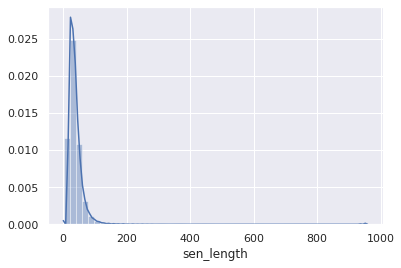

In [14]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [15]:
total_candidates_df["sen_length"].describe().astype(int)

count    3830118
mean          37
std           21
min            3
25%           24
50%           33
75%           45
max          957
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the thousands range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 37. Possible reason for this abnormality is a parsing error. Lets take a look at this 1120 word sentence.

In [16]:
total_candidates_df.query("sen_length==957").iloc[0]["text"]

'Pooled analysis of (R)-[11C]-verapamil PET data from two European centresM Bauer, M Feldmann, R Karch, W Wadsak, M Zeitlinger, MJ Koepp, M-C Asselin, E Pataraia, O LangerA13 In-vitro and in-vivo characterization of [18F]FE@SNAP and derivatives for the visualization of the melanin concentrating hormone receptor 1M Zeilinger, C Philippe, M Dumanic, F Pichler, J Pilz, M Hacker, W Wadsak, M MitterhauserA14 Reducing time in quality control leads to higher specific radioactivity of short-lived radiotracersL Nics, B Steiner, M Hacker, M Mitterhauser, W WadsakA15 In vitro 11C-erlotinib binding experiments in cancer cell lines with epidermal growth factor receptor mutationsA Traxl, Thomas Wanek, Kushtrim Kryeziu, Severin Mairinger, Johann Stanek, Walter Berger, Claudia Kuntner, Oliver LangerA16 7-[11C]methyl-6-bromopurine, a PET tracer to measure brain Mrp1 function: radiosynthesis and first PET evaluation in miceS Mairinger, T Wanek, A Traxl, M Krohn, J Stanek, T Filip, M Sauberer, C Kuntner,

The above suspicion was correct. This is a parsing error where the list of authors are combined with the title of their work for a winter symposium. The following can be found at this id link: [27090254](https://www.ncbi.nlm.nih.gov/pubmed/27090254). The goal here is to take these parsing errors into account and determine an optimal cutoff point for these sentences. Using common statsitic rules any point that is greater than two standard deviations away from the mean will be removed.

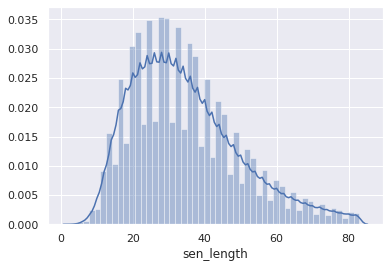

In [17]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [18]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    3712064
mean          34
std           15
min            3
25%           23
50%           32
75%           43
max           83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 3.6 million. (removed 146841 sentences).

In [24]:
total_candidates_df.to_csv("output/all_dag_candidates.tsv.xz", sep="\t", compression="xz", index=False)

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 1120 words, then the network has 1120 steps to parse through. This takes a significant amount of time (~34 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 